<a href="https://colab.research.google.com/github/AnastasiaBrinati/experiments/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **PROVA MODELLI CENTRALIZZATI PREDIZIONE INVOCATIONS' RATE**



#### Imports

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

!pip install -q -U keras-tuner
import keras_tuner as kt

# Use seaborn for pairplot.
!pip install datasets

from datasets import load_dataset

# Data

In [ ]:
dataset_60 = load_dataset("anastasiafrosted/globus_60", download_mode="force_redownload")
dataset_300 = load_dataset("anastasiafrosted/globus_300", download_mode="force_redownload")
dataset_3600 = load_dataset("anastasiafrosted/globus_3600", download_mode="force_redownload")
dataset_86400 = load_dataset("anastasiafrosted/globus_86400", download_mode="force_redownload")

df_60 = pd.DataFrame(dataset_60['train'])
df_300 = pd.DataFrame(dataset_300['train'])
df_3600 = pd.DataFrame(dataset_3600['train'])
df_86400 = pd.DataFrame(dataset_86400['train'])

# Ensure the `timestamp` column is in datetime format
df_60['timestamp'] = pd.to_datetime(df_60['timestamp'])
df_300['timestamp'] = pd.to_datetime(df_300['timestamp'])
df_3600['timestamp'] = pd.to_datetime(df_3600['timestamp'])
df_86400['timestamp'] = pd.to_datetime(df_86400['timestamp'])

In [75]:
data = df_300
data = data.set_index("timestamp")
#data.head()

In [76]:
origin = "2023-06-01"
start = "2023-07-01" # origin + prediction_lenght
end = "2023-07-07"

train_data = data["2022-12-20":origin]
valid_data = data[origin:start]
test_data = data[start:]

#### Scaling

In [77]:
from sklearn.preprocessing import StandardScaler

# Crea un'istanza dello scaler
scaler = StandardScaler()

# Per il dataset di training
scaled_train = train_data.copy()
scaled_train[scaled_train.columns.drop('avg_invocations_rate')] = scaler.fit_transform(
    train_data[train_data.columns.drop('avg_invocations_rate')]
)
train = scaled_train

# Per il dataset di validazione
scaled_valid = valid_data.copy()
scaled_valid[scaled_valid.columns.drop('avg_invocations_rate')] = scaler.transform(
    valid_data[valid_data.columns.drop('avg_invocations_rate')]
)
valid = scaled_valid

# Per il dataset di test
scaled_test = test_data.copy()
scaled_test[scaled_test.columns.drop('avg_invocations_rate')] = scaler.transform(
    test_data[test_data.columns.drop('avg_invocations_rate')]
)
test = scaled_test

#### Config (Parameters)

In [78]:
batch_size = 32
num_features = 6
sequence_lenght = 7
prediction_lenght = 7

seed = 123
neurons = 12
epochs = 10

# Models

## Forecasting one-step-ahead

In [79]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate=0.01, epochs=epochs):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=10, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

### Univariate series

In [80]:
tr = train['avg_invocations_rate']
vl = valid['avg_invocations_rate']
ts = test['avg_invocations_rate'][:-1]

In [81]:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    tr.to_numpy(),
    targets=tr[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    vl.to_numpy(),
    targets=vl[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_ds = tf.keras.utils.timeseries_dataset_from_array(
    ts.to_numpy(),
    targets=ts[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Linear Model

In [82]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[sequence_lenght])
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [83]:
fit_and_evaluate(model, train_ds, valid_ds)

Epoch 1/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0113 - mae: 0.0873 - val_loss: 0.0046 - val_mae: 0.0398
Epoch 2/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0018 - mae: 0.0344 - val_loss: 0.0040 - val_mae: 0.0363
Epoch 3/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0016 - mae: 0.0319 - val_loss: 0.0035 - val_mae: 0.0338
Epoch 4/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0014 - mae: 0.0301 - val_loss: 0.0032 - val_mae: 0.0318
Epoch 5/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0013 - mae: 0.0285 - val_loss: 0.0030 - val_mae: 0.0301
Epoch 6/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0012 - mae: 0.0273 - val_loss: 0.0028 - val_mae: 0.0290
Epoch 7/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0011 - mae: 0.0264 - val_loss: 0.0026 - val_mae: 0.0284
Epoch 8/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0010 - mae: 0.0255 - val_loss: 0.0025 - val_mae: 0.0278
Epoch 9/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/s

26187.613606452942

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


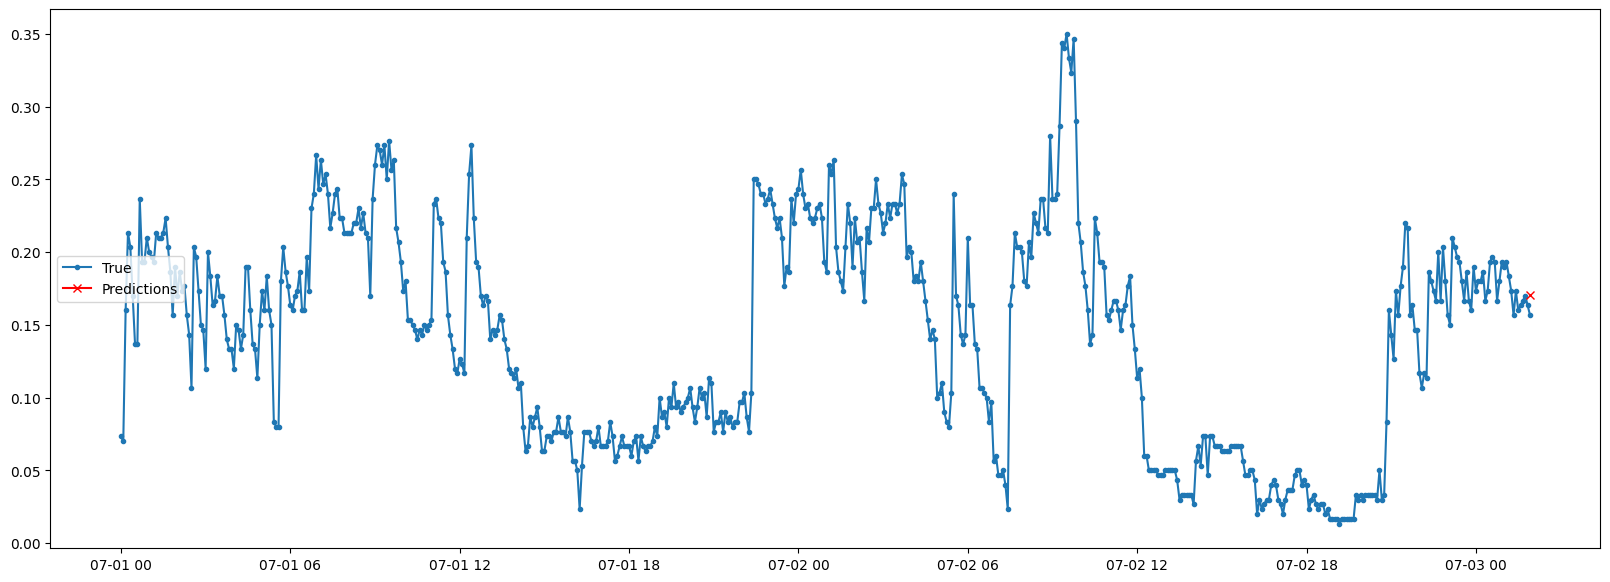

In [84]:
Y_pred = model.predict(test_ds)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test.index[-1], end=test.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.show()

#### Simple RNN

Recall that the input_shape argument ignores
the first dimension (i.e., the batch size), and since recurrent layers can accept
input sequences of any length, we can set the second dimension to None, which
means “any size”. Lastly, since we’re dealing with a univariate time series, we
need the last dimension’s size to be 1. This is why we specified the input shape
* [None, 1] : it means “univariate sequences of any length”.


In [85]:
univar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons*2, input_shape=[None, 1]),
  tf.keras.layers.Dense(1) # no activation function by default
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [86]:
fit_and_evaluate(univar_model, train_ds, valid_ds)

Epoch 1/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0049 - mae: 0.0493 - val_loss: 0.0021 - val_mae: 0.0257
Epoch 2/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 8.5722e-04 - mae: 0.0233 - val_loss: 0.0020 - val_mae: 0.0256
Epoch 3/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 7.4446e-04 - mae: 0.0217 - val_loss: 0.0020 - val_mae: 0.0256
Epoch 4/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 7.1753e-04 - mae: 0.0213 - val_loss: 0.0019 - val_mae: 0.0226
Epoch 5/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - loss: 6.9697e-04 - mae: 0.0210 - val_loss: 0.0019 - val_mae: 0.0211
Epoch 6/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 6.8249e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0232
Epoch 7/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 6.7455e-04 - mae: 0.0207 - val_loss: 0.0020 - val_mae: 0.0207
Epoch 8/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 6.7678e-04 - mae: 0.0206 - val_loss: 0.0020 - val_mae: 0.0231
Epoch 9/10
925/925

20677.484571933746

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


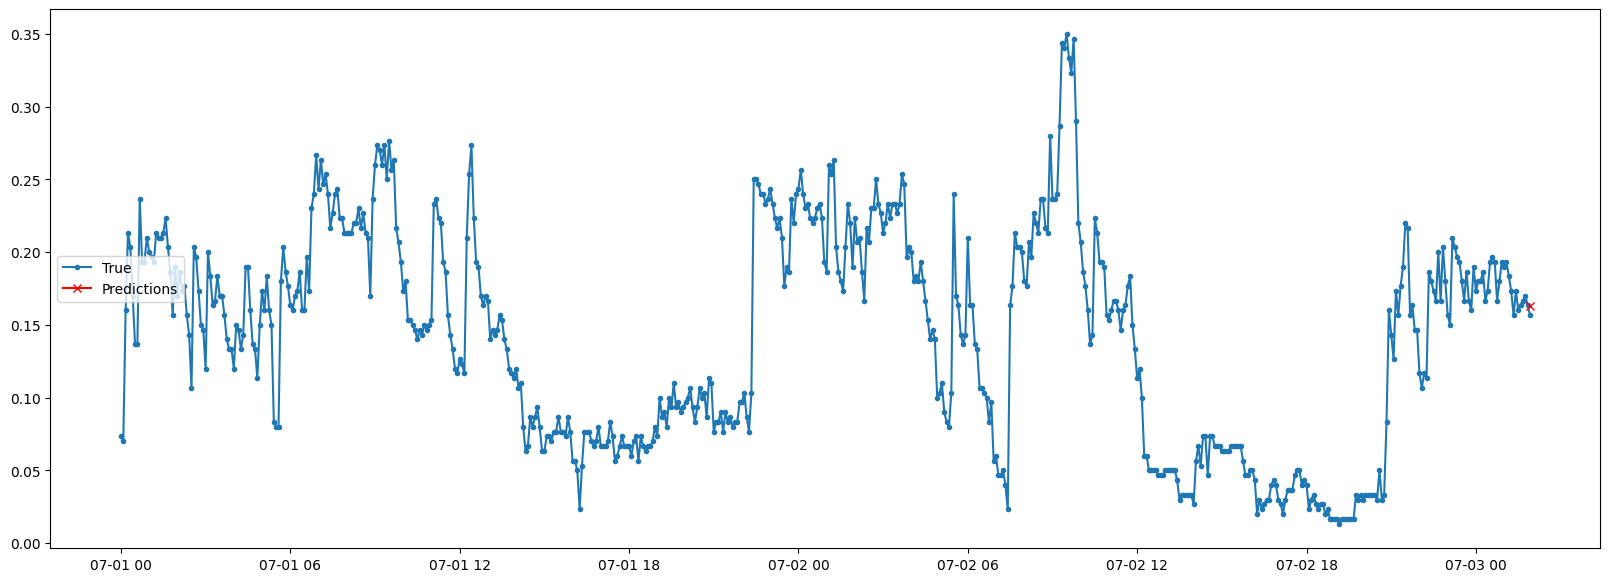

In [87]:
Y_pred = univar_model.predict(test_ds)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test.index[-1], end=test.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.show()

#### Deep RNN

In [88]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(neurons*3, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(neurons*2, return_sequences=True),
    tf.keras.layers.SimpleRNN(neurons),
    tf.keras.layers.Dense(1)
])

In [89]:
fit_and_evaluate(deep_model, train_ds, valid_ds)

Epoch 1/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.0026 - mae: 0.0428 - val_loss: 0.0024 - val_mae: 0.0354
Epoch 2/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 9.1291e-04 - mae: 0.0256 - val_loss: 0.0020 - val_mae: 0.0244
Epoch 3/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 7.7472e-04 - mae: 0.0234 - val_loss: 0.0019 - val_mae: 0.0219
Epoch 4/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 7.4615e-04 - mae: 0.0231 - val_loss: 0.0022 - val_mae: 0.0365
Epoch 5/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 7.3193e-04 - mae: 0.0227 - val_loss: 0.0020 - val_mae: 0.0263
Epoch 6/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 7.0064e-04 - mae: 0.0218 - val_loss: 0.0019 - val_mae: 0.0224
Epoch 7/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 7.0486e-04 - mae: 0.0223 - val_loss: 0.0020 - val_mae: 0.0217
Epoch 8/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 7.0615e-04 - mae: 0.0219 - val_loss: 0.0020 - val_mae: 0.0273
Epoch 9/10
9

20709.44756269455

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


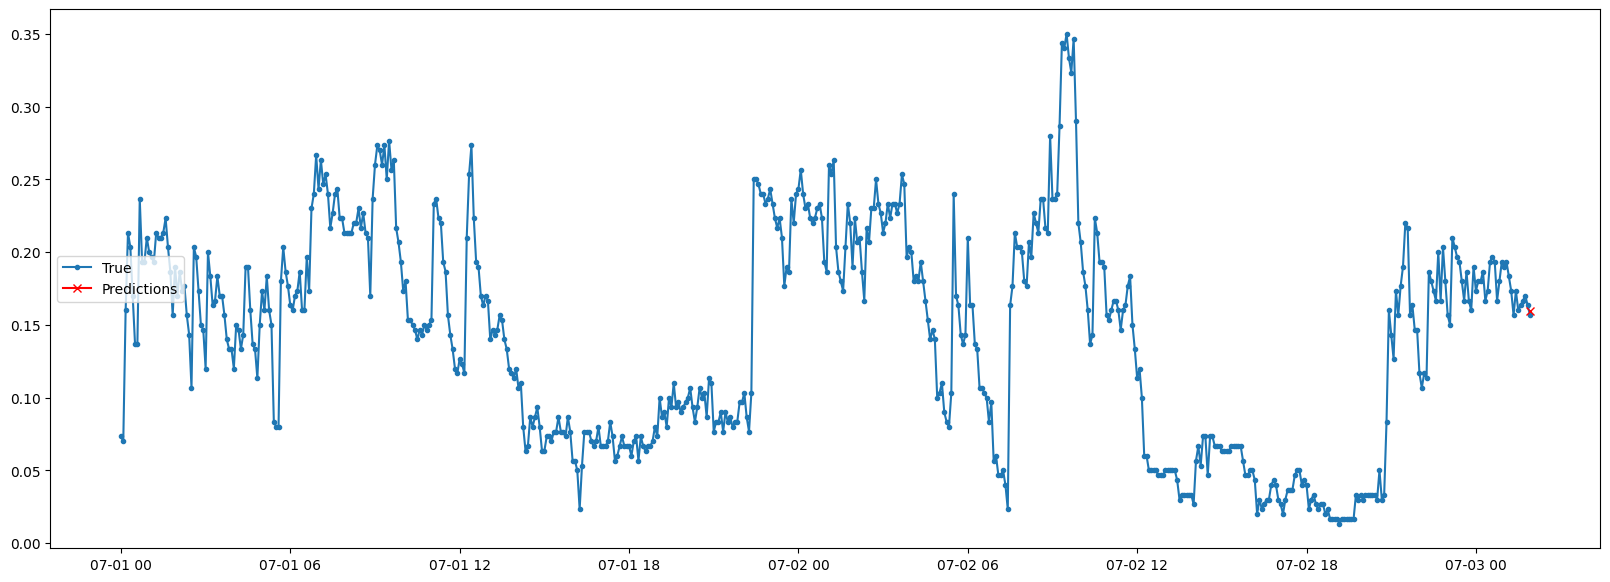

In [90]:
Y_pred = deep_model.predict(test_ds)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test.index[-1], end=test.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.show()

### Multivariate Series

In [91]:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    train,
    targets=train['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid,
    targets=valid['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    test,
    targets=test['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Simple RNN

Notice that the only difference from the univar_model RNN we built earlier
is the input shape: at each time step, the model now receives num_features inputs instead of one.

In [92]:
mulvar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons, input_shape=[None, num_features]),
  tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [93]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds)

Epoch 1/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0134 - mae: 0.0839 - val_loss: 0.0024 - val_mae: 0.0285
Epoch 2/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0011 - mae: 0.0288 - val_loss: 0.0022 - val_mae: 0.0253
Epoch 3/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 9.2155e-04 - mae: 0.0260 - val_loss: 0.0021 - val_mae: 0.0240
Epoch 4/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 8.7677e-04 - mae: 0.0251 - val_loss: 0.0021 - val_mae: 0.0236
Epoch 5/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 8.4292e-04 - mae: 0.0245 - val_loss: 0.0021 - val_mae: 0.0232
Epoch 6/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 8.2405e-04 - mae: 0.0241 - val_loss: 0.0021 - val_mae: 0.0228
Epoch 7/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 8.0239e-04 - mae: 0.0237 - val_loss: 0.0021 - val_mae: 0.0229
Epoch 8/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 7.9032e-04 - mae: 0.0235 - val_loss: 0.0021 - val_mae: 0.0228
Epoch 9/10
925/925 ━━━━━━━

22581.21781051159

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


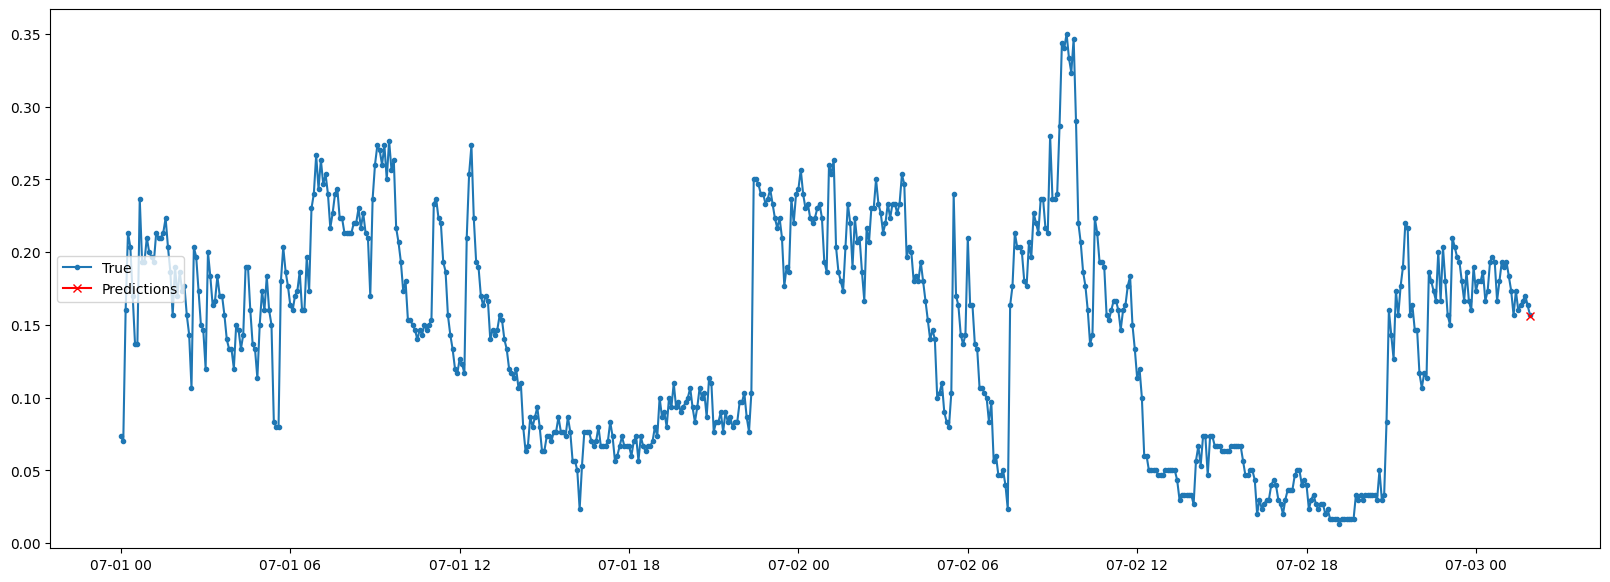

In [94]:
Y_pred = mulvar_model.predict(test_mulvar_ds)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test.index[-1], end=test.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.show()

## Forecasting Several Time Steps Ahead

### Univariate Series

Consideriamo sempre:
* tr = train['avg_invocations_rate']
* vl = valid['avg_invocations_rate']

#### Simple RNN

The first option is to take the univar_model RNN we trained earlier for the
rail time series, make it predict the next value, and add that value to the inputs,
acting as if the predicted value had actually occurred; we would then use the
model again to predict the following value, and so on.

---
If the model makes an error at one time step, then the forecasts for the
following time steps are impacted as well: the errors tend to accumulate.
So, it’s preferable to use this technique only for a small number of steps.

 1 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
 2 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
 3 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
 4 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
 5 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
 6 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 7 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


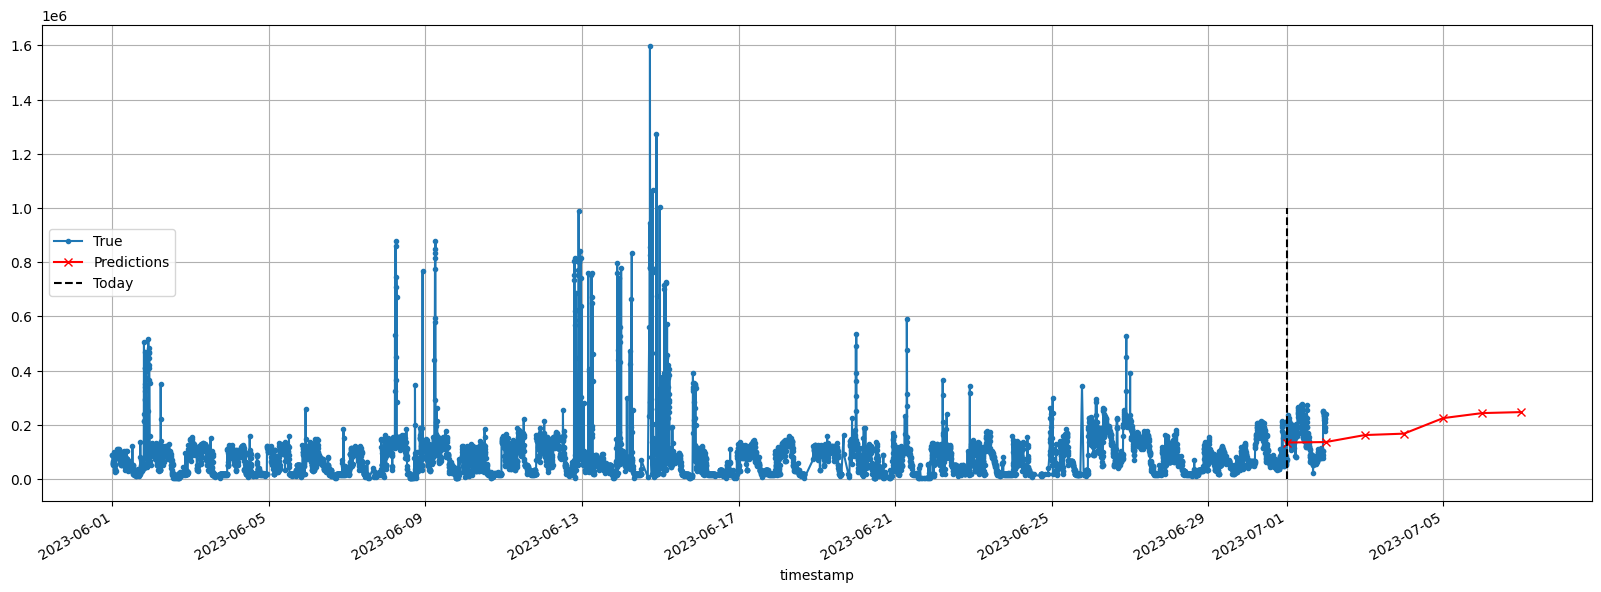

In [95]:
X = ts.to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
for step_ahead in range(prediction_lenght):
  print(f" {step_ahead+1} step ahead")
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(ts * 1e6)[start:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, 0, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

### Multivariate Series

In [96]:
def split_inputs_and_targets(mulvar_series, ahead=prediction_lenght, target_col=1):
  return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    train,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

#### Sequence-to-Vector RNN

Train an RNN to predict the next 14 values in one shot.

In [97]:
ahead_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [98]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds)

Epoch 1/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.2079 - mae: 0.4538 - val_loss: 0.0964 - val_mae: 0.2645
Epoch 2/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1440 - mae: 0.3544 - val_loss: 0.0934 - val_mae: 0.2500
Epoch 3/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.1400 - mae: 0.3461 - val_loss: 0.0928 - val_mae: 0.2489
Epoch 4/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.1387 - mae: 0.3435 - val_loss: 0.0931 - val_mae: 0.2592
Epoch 5/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.1374 - mae: 0.3410 - val_loss: 0.0918 - val_mae: 0.2404
Epoch 6/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.1365 - mae: 0.3390 - val_loss: 0.0922 - val_mae: 0.2569
Epoch 7/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.1360 - mae: 0.3386 - val_loss: 0.0928 - val_mae: 0.2674
Epoch 8/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 0.1359 - mae: 0.3378 - val_loss: 0.0916 - val_mae: 0.2503
Epoch 9/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms

240395.36714553833

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


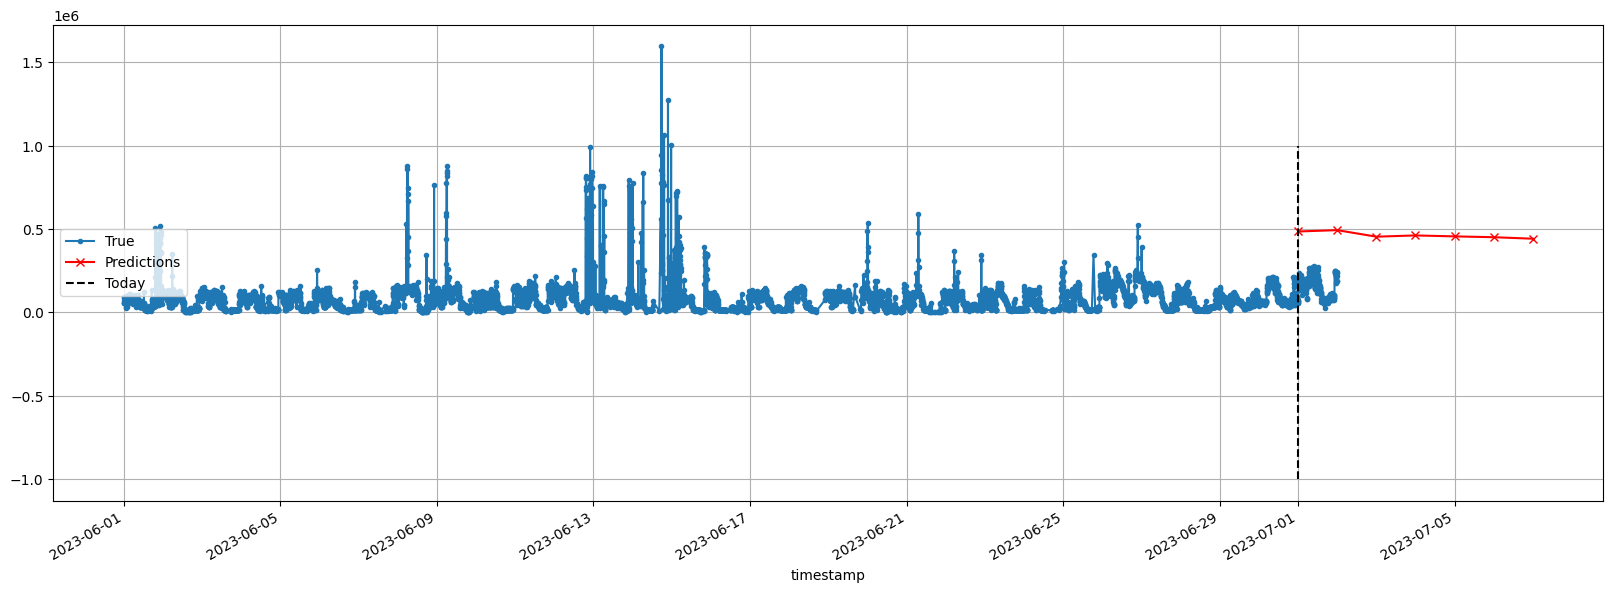

In [99]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = ahead_model.predict(X) # shape [1, 14]
Y_pred = pd.Series(Y_pred[0], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### Sequence-to-Sequence RNN

In [100]:
def to_windows(dataset, length):
  dataset = dataset.window(length, shift=1, drop_remainder=True)
  return dataset.flat_map(lambda window_ds: window_ds.batch(length))

def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1, batch_size=32, shuffle=False, seed=None):
  ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
  ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
  if shuffle:
    ds = ds.shuffle(8 * batch_size, seed=seed)
  return ds.batch(batch_size)

In [101]:
seq2seq_train = to_seq2seq_dataset(train, seq_length=sequence_lenght, ahead=prediction_lenght, shuffle=True, seed=seed)
seq2seq_valid = to_seq2seq_dataset(valid, seq_length=sequence_lenght, ahead=prediction_lenght)

Instead of training the model to forecast the next 14 values only at the very last time step, we can train it to forecast the next 14 values at each and every time step.
In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN.

* The targets are sequences of consecutive windows, shifted by one time step at each time step;
* The target is not a vector anymore, but a sequence of the same length as the inputs, containing a (prediction_lenght)-dimensional vector at each step.

It is almost identical to our previous model: the only difference is that we set
return_sequences=True in the SimpleRNN layer. This way, it will
output a sequence of vectors (each of size 'batch_size'), instead of outputting a single
vector at the last time step. The Dense layer is smart enough to handle
sequences as input: it will be applied at each time step, taking a 'batch_size'-dimensional
vector as input and outputting a 'prediction_lenght'-dimensional vector.

In [102]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(neurons, return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [103]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid)

Epoch 1/10
    921/Unknown 9s 9ms/step - loss: 0.1892 - mae: 0.4356

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


925/925 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.1892 - mae: 0.4355 - val_loss: 0.0995 - val_mae: 0.2710
Epoch 2/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.1416 - mae: 0.3559 - val_loss: 0.0962 - val_mae: 0.2580
Epoch 3/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.1326 - mae: 0.3378 - val_loss: 0.0948 - val_mae: 0.2570
Epoch 4/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.1293 - mae: 0.3313 - val_loss: 0.0935 - val_mae: 0.2505
Epoch 5/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.1274 - mae: 0.3273 - val_loss: 0.0934 - val_mae: 0.2564
Epoch 6/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - loss: 0.1262 - mae: 0.3259 - val_loss: 0.0928 - val_mae: 0.2485
Epoch 7/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.1254 - mae: 0.3244 - val_loss: 0.0932 - val_mae: 0.2606
Epoch 8/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.1249 - mae: 0.3244 - val_loss: 0.0924 - val_mae: 0.2531
Epoch 9/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/st

248544.3949699402

Perchè sembra migliorare? dovrebbe peggiorare (?)

In [104]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(prediction_lenght):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=valid.index[sequence_lenght + ahead : -prediction_lenght + ahead])
    mae = (preds - valid["avg_invocations_rate"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
MAE for +1: 399,488
MAE for +2: 381,506
MAE for +3: 369,471
MAE for +4: 358,554
MAE for +5: 348,438
MAE for +6: 350,529
MAE for +7: 339,884


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


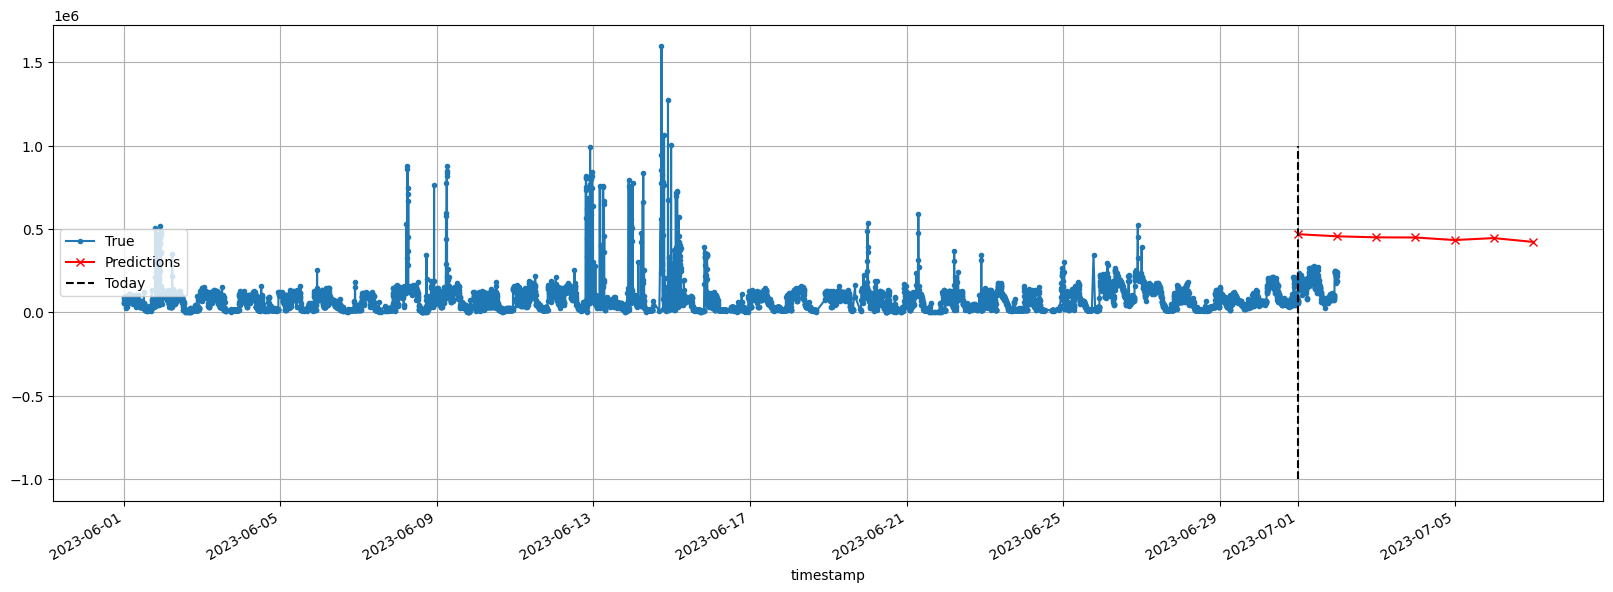

In [105]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### RNN with layer normalization

In [106]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [107]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(neurons), return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [ ]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid)

Epoch 1/10
    919/Unknown 14s 13ms/step - loss: 0.2463 - mae: 0.5185

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


925/925 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.2460 - mae: 0.5179 - val_loss: 0.0987 - val_mae: 0.2745
Epoch 2/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 0.1421 - mae: 0.3614 - val_loss: 0.0976 - val_mae: 0.2800
Epoch 3/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 0.1294 - mae: 0.3389 - val_loss: 0.0961 - val_mae: 0.2726
Epoch 4/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 0.1266 - mae: 0.3323 - val_loss: 0.0955 - val_mae: 0.2713
Epoch 5/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 0.1253 - mae: 0.3289 - val_loss: 0.0951 - val_mae: 0.2725
Epoch 6/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.1248 - mae: 0.3289 - val_loss: 0.0946 - val_mae: 0.2690
Epoch 7/10
564/925 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.1132 - mae: 0.3132

In [ ]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = custom_ln_model.predict(X)  # but then [0, -1] because only the last time step's output

Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

 #### LSTM

In [ ]:
lstm = tf.keras.Sequential([
  tf.keras.layers.LSTM(neurons, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

In [ ]:
fit_and_evaluate(lstm, seq2seq_train, seq2seq_valid)

In [ ]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = lstm.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### GRU

The GRU cell is a simplified version of the LSTM cell...

In [ ]:
gru = tf.keras.Sequential([
  tf.keras.layers.GRU(neurons, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

In [ ]:
fit_and_evaluate(gru, seq2seq_train, seq2seq_valid)

In [ ]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = gru.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### CNN

In [ ]:
seq2seq_cnn_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons*2, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Conv1D(prediction_lenght, kernel_size=1)
])

In [ ]:
fit_and_evaluate(seq2seq_cnn_model, seq2seq_train, seq2seq_valid)

In [ ]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_cnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

LSTM and GRU cells are one of the main reasons behind the success of RNNs.
Yet while they can tackle much longer sequences than simple RNNs, they still
have a fairly limited short-term memory, and they have a hard time learning
long-term patterns in sequences of 100 time steps or more, such as audio
samples, long time series, or long sentences. One way to solve this is to shorten
the input sequences; for example, using 1D convolutional layers.

In [ ]:
stride = 2
k_size = 4

conv_rnn_model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=k_size, strides=stride, activation="relu", input_shape=[None, num_features]),
  tf.keras.layers.GRU(batch_size, return_sequences=True),
  tf.keras.layers.Dense(prediction_lenght)
])

In [ ]:
longer_train = to_seq2seq_dataset(train, seq_length=sequence_lenght*2, shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(valid, seq_length=sequence_lenght*2)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))

In [ ]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid)

In [ ]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = conv_rnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

## ARMA family



In [ ]:
from statsmodels.tsa.arima.model import ARIMA

Check for stationarity with the Augmented Dickey-Fuller test

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train['avg_invocations_rate'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


In [ ]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(train['avg_invocations_rate'], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(train['avg_invocations_rate'], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

order=(p, d, q):
* p = the past p values of the time series, "how far back into the past the model should look";
* d = *order of integration*, running d consecutive rounds of differencing computes an approximation of the dth order derivative of the time series, so it will eliminate polynomial trends up to degree d.
* q = the past q forecast errors ε(t);

seasonal_order=(P, D, Q, s)
* P = , D = , Q =  : to model the time series at  (t–s), (t–2s), (t–3s);
* s = the period of the seasonal pattern.


In [ ]:
trimmed_valid = vl.iloc[:-prediction_lenght]
# in realtà dal test risulta stazionaria, ma le performance sembrano migliori
arima = ARIMA(trimmed_valid, order=(3, 1, 4))
arima = arima.fit()

In [ ]:
# Forecasting
forecast = arima.forecast(steps=prediction_lenght)

plt.figure(figsize=(20, 6))
# Plot the forecast
# original data: full length
plt.plot(vl.index, vl, label='Observed')
plt.plot(pd.date_range(trimmed_valid.index[-1], periods=prediction_lenght, freq='D'), forecast, label='Forecast', color='red')
plt.axvline(trimmed_valid.index[-1], linestyle='--', color='black', label='Forecast Start')
plt.legend()
plt.grid()
plt.show()